## Decision tree

El objetivo aquí es entrenar a un clasificador binario en el conjunto de datos de entrenamiento para predecir la columna
ingreso_esfuerzo que tiene dos valores posibles "> 50K" y "<= 50K" y evaluar la precisión del clasificador con el conjunto
de datos de prueba. usando un csv de una encuesta de personas de estados unidos

In [23]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#Cargamos los datos
training_data = 'adult-training.csv'
test_data = 'adult-test.csv'

In [24]:
#Hacemos referencia con las columnas con las que vamos a trabajar
columns = ['Age','Workclass','fnlgwt','Education','EdNum','MaritalStatus',
           'Occupation','Relationship','Race','Sex','CapitalGain','CapitalLoss',
           'HoursPerWeek','Country','Income']
#reamos un set de train y asignamos el la variable y las columnas
df_train_set = pd.read_csv(training_data, names=columns)
df_test_set = pd.read_csv(test_data, names=columns, skiprows=1)
df_train_set.drop('fnlgwt', axis=1, inplace=True)
df_test_set.drop('fnlgwt', axis=1, inplace=True)

In [25]:


df_train_set.head()



,Age,Workclass,Education,EdNum,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,Country,Income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [26]:
# reemplazar el carácter especial a "Unknown"
for i in df_train_set.columns:
    df_train_set[i].replace(' ?', 'Unknown', inplace=True)
    df_test_set[i].replace(' ?', 'Unknown', inplace=True)
# Eliminar espacios
for col in df_train_set.columns:
    if df_train_set[col].dtype != 'int64':
        df_train_set[col] = df_train_set[col].apply(lambda val: val.replace(" ", ""))
        df_train_set[col] = df_train_set[col].apply(lambda val: val.replace(".", ""))
        df_test_set[col] = df_test_set[col].apply(lambda val: val.replace(" ", ""))
        df_test_set[col] = df_test_set[col].apply(lambda val: val.replace(".", ""))

In [27]:
# Hacemos una limpieza a los datos, para trabajar nomas con algunos
df_train_set.drop(["Country", "Education"], axis=1, inplace=True)
df_test_set.drop(["Country", "Education"], axis=1, inplace=True)

colnames = list(df_train_set.columns)
colnames.remove('Age')
colnames.remove('EdNum')
colnames = ['AgeGroup', 'Education'] + colnames

labels = ["{0}-{1}".format(i, i + 9) for i in range(0, 100, 10)]
df_train_set['AgeGroup'] = pd.cut(df_train_set.Age, range(0, 101, 10), right=False, labels=labels)
df_test_set['AgeGroup'] = pd.cut(df_test_set.Age, range(0, 101, 10), right=False, labels=labels)

labels = ["{0}-{1}".format(i, i + 4) for i in range(0, 20, 5)]
df_train_set['Education'] = pd.cut(df_train_set.EdNum, range(0, 21, 5), right=False, labels=labels)
df_test_set['Education'] = pd.cut(df_test_set.EdNum, range(0, 21, 5), right=False, labels=labels)

df_train_set = df_train_set[colnames]
df_test_set = df_test_set[colnames]

In [28]:
#Vemos cuantos datos hay menos a 50k y cuantos mayores en los datos de entrenamiento
df_train_set.Income.value_counts()

<=50K    24720
>50K      7841
Name: Income, dtype: int64

In [29]:
# Hacemos lo mismo pero con los datos de test
df_test_set.Income.value_counts()

<=50K    12435
>50K      3846
Name: Income, dtype: int64

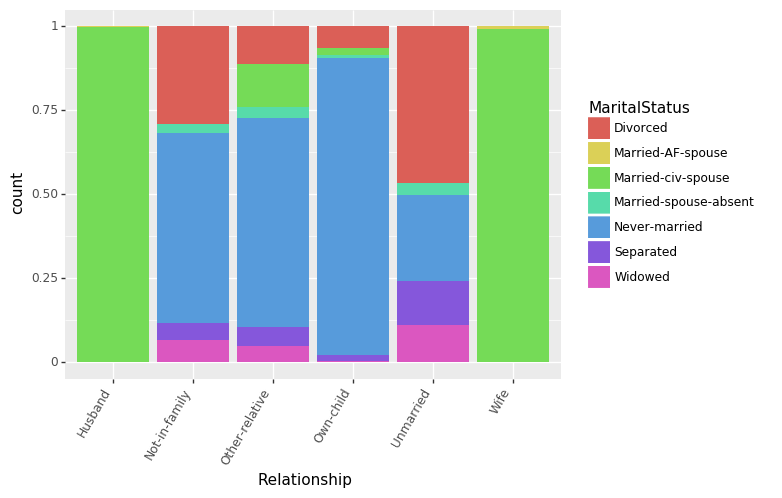

<ggplot: (-9223372024666008724)>

In [30]:
#Aquí hacemos una visualización para ver la relación con el estatus marital, usamos un waterfall chart
(ggplot(df_train_set, aes(x = "Relationship", fill = "MaritalStatus"))
 + geom_bar(position="fill")
 + theme(axis_text_x = element_text(angle = 60, hjust = 1))
)

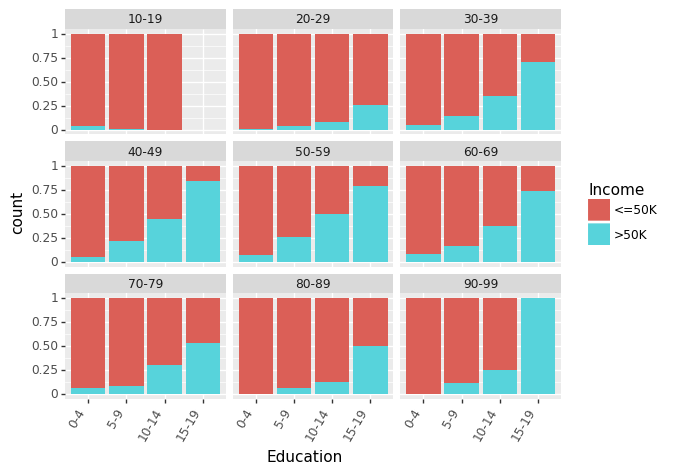

<ggplot: (-9223372024663628660)>

In [31]:
#Aqui hacemos una visualizacion pero en grupo, ya que usamos la relacion de ingresos y la educacion por grupo de edades
(ggplot(df_train_set, aes(x = "Education", fill = "Income"))
 + geom_bar(position="fill")
 + theme(axis_text_x = element_text(angle = 60, hjust = 1))
 + facet_wrap('~AgeGroup')
)

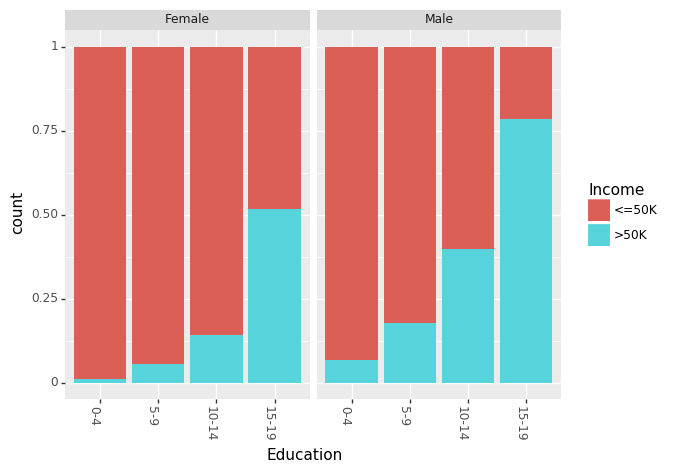

<ggplot: (-9223372024663587980)>

In [32]:
# Es parecido a la enterior solo que aqui visualizamos la relacion de educacion e ingresos por sexo
(ggplot(df_train_set, aes(x = "Education", fill = "Income"))
 + geom_bar(position="fill")
 + theme(axis_text_x = element_text(angle = -90, hjust = 1))
 + facet_wrap('~Sex')
)

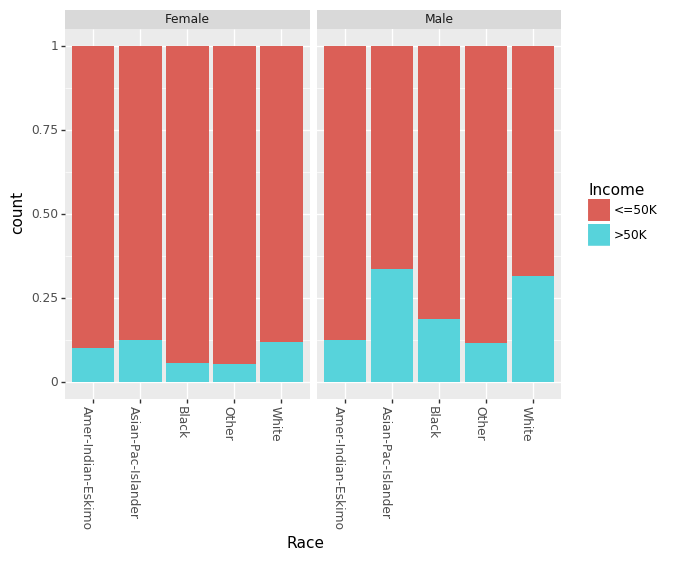

<ggplot: (-9223372024659779404)>

In [33]:
#Lo mismo pero aqui es la raza e ingresos por sexo
(ggplot(df_train_set, aes(x = "Race", fill = "Income"))
 + geom_bar(position="fill")
 + theme(axis_text_x = element_text(angle = -90, hjust = 1))
 + facet_wrap('~Sex')
)

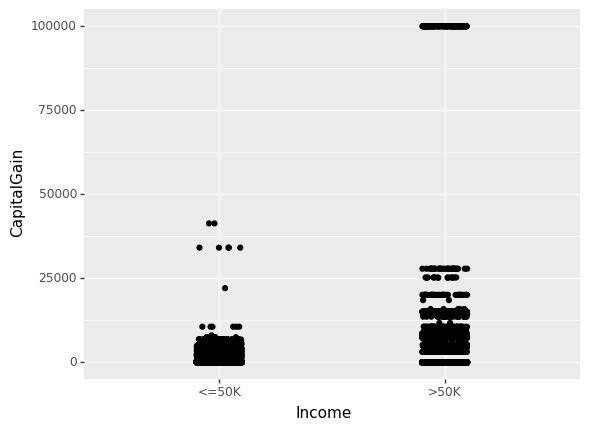

<ggplot: (-9223372024659906040)>

In [34]:
#Usamos una grafica de distribucion para entender un poco la relacion de la ganancia capital por los ingresos
(ggplot(df_train_set, aes(x="Income", y="CapitalGain"))
 + geom_jitter(position=position_jitter(0.1))
)

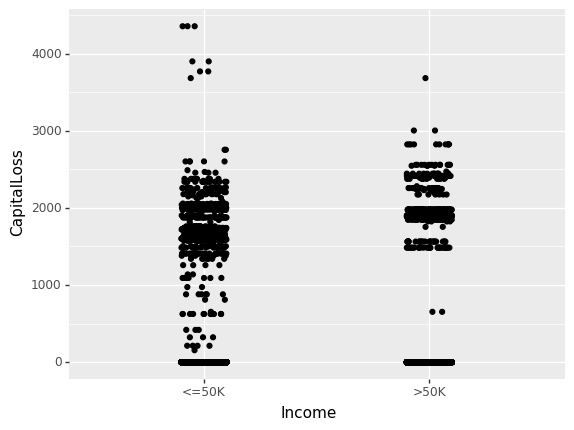

<ggplot: (-9223372024659616892)>

In [35]:
# Es parecido solo que aqui notamos la perdida capital con relación del ingreso
(ggplot(df_train_set, aes(x="Income", y="CapitalLoss"))
 + geom_jitter(position=position_jitter(0.1))
)

In [36]:
#Realizamos un mapper y referimos las columnas que utilizara
mapper = DataFrameMapper([
    ('AgeGroup', LabelEncoder()),
    ('Education', LabelEncoder()),
    ('Workclass', LabelEncoder()),
    ('MaritalStatus', LabelEncoder()),
    ('Occupation', LabelEncoder()),
    ('Relationship', LabelEncoder()),
    ('Race', LabelEncoder()),
    ('Sex', LabelEncoder()),
    ('Income', LabelEncoder())
], df_out=True, default=None)
#En esta parte aterrizamos todo el algoritmo, ya despues de entrenar los datos
#y saber el comportamiento
cols = list(df_train_set.columns)
cols.remove("Income")
cols = cols[:-3] + ["Income"] + cols[-3:]

df_train = mapper.fit_transform(df_train_set.copy())
df_train.columns = cols

df_test = mapper.transform(df_test_set.copy())
df_test.columns = cols

cols.remove("Income")
x_train, y_train = df_train[cols].values, df_train["Income"].values
x_test, y_test = df_test[cols].values, df_test["Income"].values

In [37]:
#Aqui podemos notar que tan bueno es nuestro algoritmo, ya que podemos 
#saber despues de pasarlo por las pruebas que tan efectivo es
treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(x_train, y_train)
treeClassifier.score(x_test, y_test)

0.8355137890792949

## Matriz de confusión

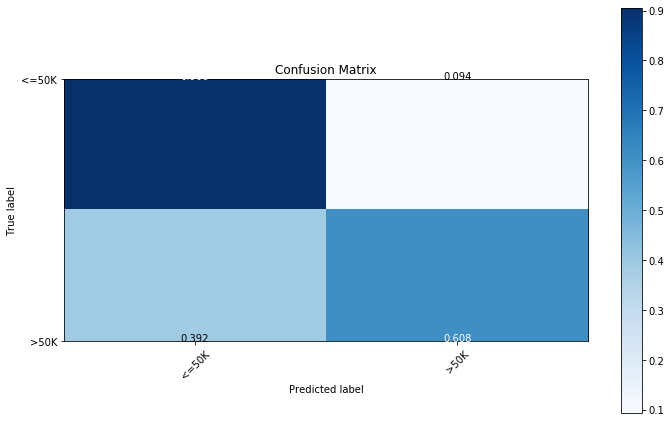

In [38]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred = treeClassifier.predict(x_test)
cfm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["<=50K", ">50K"], normalize=True)

In [ ]:
#La matriz de consusión nos sirve para tener una idea más clara del comportamiento del algoritmo
#y como podemos visualizar la acertividad por las clases con el csv test

In [39]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'max_features':(None, 9, 6),
     'max_depth':(None, 24, 16),
     'min_samples_split': (2, 4, 8),
     'min_samples_leaf': (16, 4, 12)
}

clf = GridSearchCV(treeClassifier, parameters, cv=5, n_jobs=4)
clf.fit(x_train, y_train)
clf.best_score_, clf.score(x_test, y_test), clf.best_params_

(0.859463775682565,
 0.857379767827529,
 {'max_depth': 16,
  'max_features': 9,
  'min_samples_leaf': 12,
  'min_samples_split': 2})

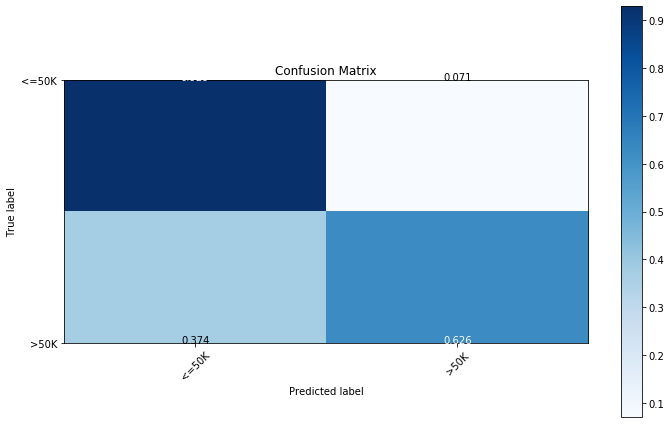

In [40]:
y_pred = clf.predict(x_test)
cfm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["<=50K", ">50K"], normalize=True)

In [ ]:
#Hacemos casi lo mismo que el anterior

## Regresión Logistica

Usare el algoritmo para clasificar si el usuario que visita un sitio web usa como sistema operativo Windows, Macintosh o Linux.

Nuestra información de entrada son 4 características que tomé de una web que utiliza Google Analytics y son:

    Duración de la visita en Segundos
    Cantidad de Páginas Vistas durante la Sesión
    Cantidad de Acciones del usuario (click, scroll, uso de checkbox, sliders,etc)
    Suma del Valor de las acciones (cada acción lleva asociada una valoración de importancia)
    

In [41]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [42]:
dataframe = pd.read_csv(r"usuarios_win_mac_lin.csv")
dataframe.head()

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


In [43]:
dataframe.describe()

,duracion,paginas,acciones,valor,clase
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,111.075729,2.041176,8.723529,32.676471,0.752941
std,202.453200,1.500911,9.136054,44.751993,0.841327
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,11.000000,1.000000,3.000000,8.000000,0.000000
50%,13.000000,2.000000,6.000000,20.000000,0.000000
75%,108.000000,2.000000,10.000000,36.000000,2.000000
max,898.000000,9.000000,63.000000,378.000000,2.000000


In [44]:
#Luego analizaremos cuantos resultados tenemos de cada tipo usando la función groupby y vemos que tenemos 
#86 usuarios «Clase 0», es decir Windows, 40 usuarios Mac y 44 de Linux
print(dataframe.groupby('clase').size())

clase
0    86
1    40
2    44
dtype: int64


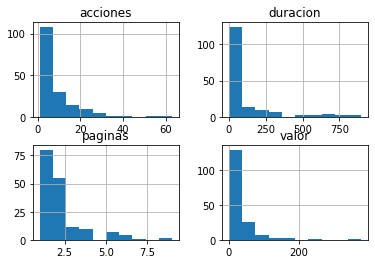

In [45]:
#Primero visualizamos en formato de historial los cuatro Features de entrada, podemos ver gráficamente entre qué valores se 
#comprenden sus mínimos y máximos
dataframe.drop(['clase'],1).hist()
plt.show()

Y también podemos interrelacionar las entradas de a pares, para ver como se concentran linealmente las salidas de usuarios por colores: Sistema Operativo Windows en azul, Mac en verde y Linux en rojo.

C:\Users\Usuario\Anaconda\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


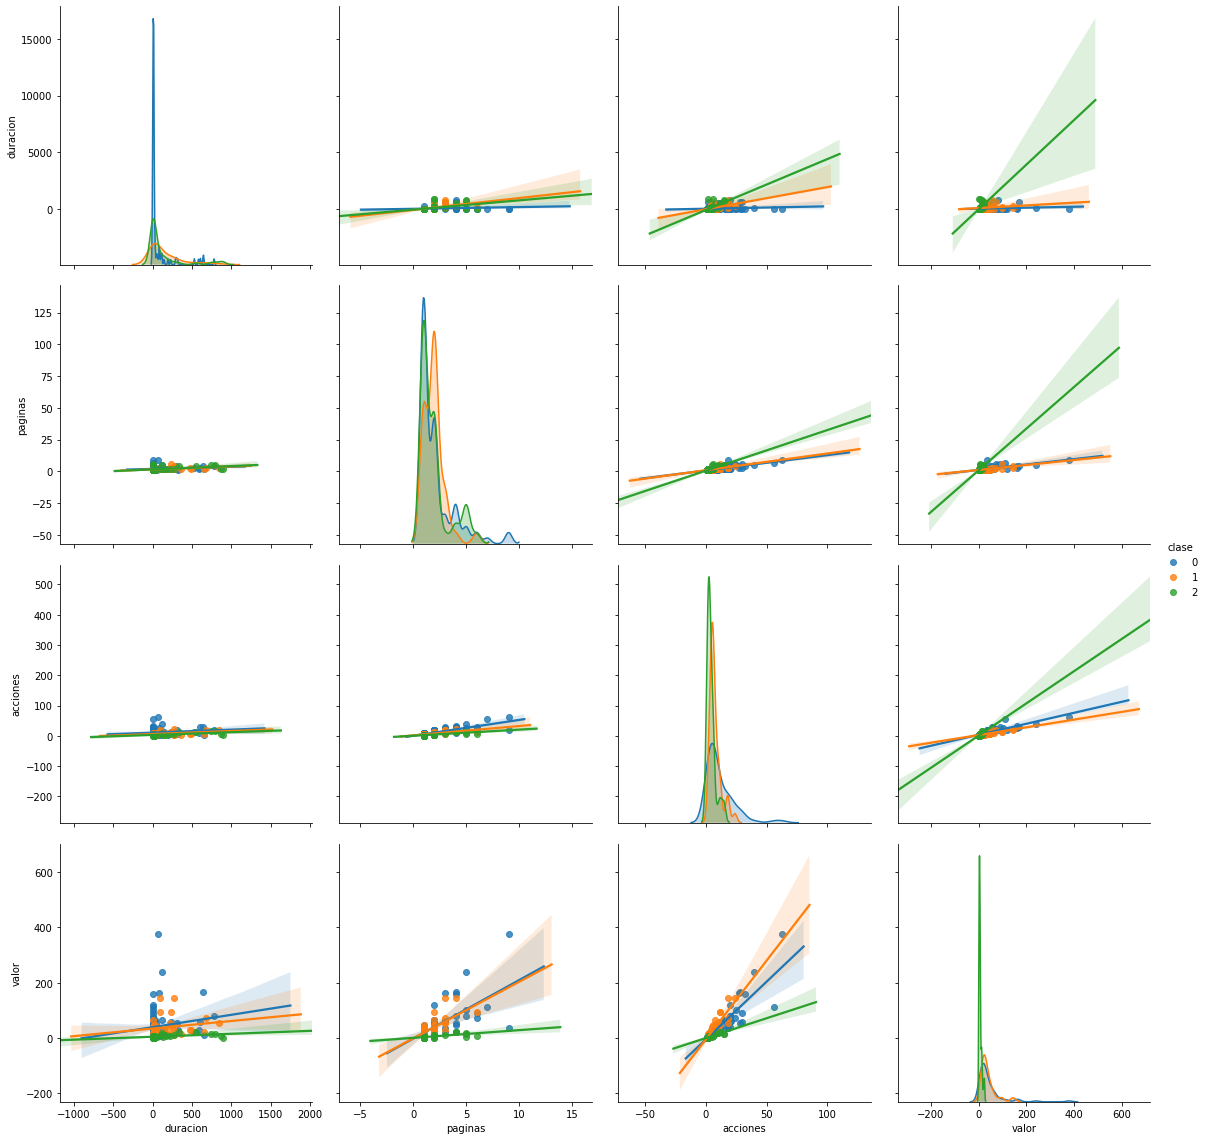

In [46]:
sb.pairplot(dataframe.dropna(), hue='clase',size=4,vars=["duracion", "paginas","acciones","valor"],kind='reg')

In [47]:
#Ahora cargamos las variables de las 4 columnas de entrada en X excluyendo la columna clase
X = np.array(dataframe.drop(['clase'],1))
y = np.array(dataframe['clase'])
X.shape

(170, 4)

In [50]:
#Y creamos nuestro modelo y hacemos que se ajuste (fit) a nuestro conjunto de entradas X y salidas ‘y’
model = linear_model.LogisticRegression()
model.fit(X,y)

C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
# Una vez compilado nuestro modelo, le hacemos clasificar todo nuestro conjunto de entradas X utilizando el método
predictions = model.predict(X)
print(predictions)[0:5]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 2 2
 2 2 2 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 1 0 1 0 0 2 0
 0 1 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 1 0 0 2 1 2 1 0 0 0 0 0 0 0 0 0 0 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


TypeError: 'NoneType' object is not subscriptable

In [52]:
#Y confirmamos cuan bueno fue nuestro modelo
model.score(X,y)

0.7764705882352941

In [53]:
#utilizando 80% de registros para entrenamiento y 20% para validar
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)

In [54]:
#Volvemos a compilar nuestro modelo de Regresión Logística pero esta vez sólo con 80%
name='Logistic Regression'
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

Logistic Regression: 0.743407 (0.115752)


C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Usuario\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

In [55]:
#Y ahora hacemos las predicciones -en realidad clasificación- utilizando nuestro «cross validation set»
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))

0.8529411764705882


In [56]:
print(confusion_matrix(Y_validation, predictions))

[[16  0  2]
 [ 3  3  0]
 [ 0  0 10]]


In [57]:
print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       1.00      0.50      0.67         6
           2       0.83      1.00      0.91        10

    accuracy                           0.85        34
   macro avg       0.89      0.80      0.81        34
weighted avg       0.87      0.85      0.84        34

